In [1]:
import pandas as pd
import numpy as np
import wandb
wandb.login()

# Load the data located in /Dataset_creation/df_AD.csv
df_AD = pd.read_pickle('Dataset_creation/df_AD_timestamps.pkl')
# Could be used to remove AttributeError: 'bool' object has no attribute 'any'
# df_AD.replace(to_replace=pd.NA, value=None, inplace=True)
# Reset the index
df_AD = df_AD.reset_index(drop=True)

# df_AD.head()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lbissot (high-contrast-imaging). Use `wandb login --relogin` to force relogin


In [2]:
features_to_keep = ['ESO INS4 FILT3 NAME', 'ESO INS4 OPTI22 NAME', \
    'ESO AOS VISWFS MODE', 'ESO TEL AMBI WINDSP', 'SCFOVROT', 'ESO TEL AMBI RHUM', \
        'HIERARCH ESO INS4 TEMP422 VAL', 'HIERARCH ESO TEL TH M1 TEMP', 'HIERARCH ESO TEL AMBI TEMP', \
            'ESO DET NDIT', 'ESO DET SEQ1 DIT', 'SIMBAD_FLUX_G', 'SIMBAD_FLUX_H', 'SEEING_MEDIAN', \
                'SEEING_STD', 'COHERENCE_TIME_MEDIAN', 'COHERENCE_TIME_STD', 'SEPARATION', 'NSIGMA_CONTRAST']

                # 'EFF_NFRA', 'EFF_ETIM', 'SR_AVG' are not included due to the high number of NaN values
                # 'SC MODE' is not included because it is 0 for all the rows

categorical_features = ['ESO INS4 FILT3 NAME', 'ESO INS4 OPTI22 NAME', 'ESO AOS VISWFS MODE']

# The numerical features are the ones that are not categorical
numerical_features = list(set(features_to_keep) - set(categorical_features) - set(['SEPARATION', 'NSIGMA_CONTRAST']))

# Get a dataframe containing only the columns we want to keep
df_AD = df_AD[features_to_keep]

# Convert the strings to numbers in order to transform it into a tensor
df_AD['ESO INS4 FILT3 NAME'] = pd.factorize(df_AD['ESO INS4 FILT3 NAME'])[0]
df_AD['ESO INS4 OPTI22 NAME'] = pd.factorize(df_AD['ESO INS4 OPTI22 NAME'])[0]
df_AD['ESO AOS VISWFS MODE'] = pd.factorize(df_AD['ESO AOS VISWFS MODE'])[0]
# df_AD['SC MODE'] = pd.factorize(df_AD['SC MODE'])[0]

# Convert the columns 'SEPARATION' and 'NSIGMA_CONTRAST' to numpy arrays
separation = np.array(df_AD['SEPARATION'])
nsigma_contrast = np.array(df_AD['NSIGMA_CONTRAST'])

df_AD.describe()


,ESO INS4 FILT3 NAME,ESO INS4 OPTI22 NAME,ESO AOS VISWFS MODE,ESO TEL AMBI WINDSP,SCFOVROT,ESO TEL AMBI RHUM,HIERARCH ESO INS4 TEMP422 VAL,HIERARCH ESO TEL TH M1 TEMP,HIERARCH ESO TEL AMBI TEMP,ESO DET NDIT,ESO DET SEQ1 DIT,SIMBAD_FLUX_G,SIMBAD_FLUX_H,SEEING_MEDIAN,SEEING_STD,COHERENCE_TIME_MEDIAN,COHERENCE_TIME_STD
count,843.000000,843.000000,843.000000,843.000000,843.000000,843.000000,834.000000,843.000000,843.000000,843.000000,843.000000,833.000000,807.000000,745.000000,745.000000,745.000000,743.000000
mean,0.820878,0.778173,2.575326,6.139632,30.398393,11.806050,14.618345,11.958956,13.343037,9.868327,39.516710,8.104576,6.492323,0.988319,0.129866,0.004116,0.000642
std,0.981995,0.719196,1.778055,3.727800,28.670754,9.220288,1.872666,2.068456,2.609030,14.634274,26.860949,2.311218,1.613972,0.354757,0.094224,0.003633,0.000872
min,0.000000,0.000000,0.000000,0.130000,0.015907,3.000000,8.100000,4.490000,2.480000,1.000000,0.837464,2.722356,1.570000,0.360000,0.005774,0.000650,0.000023
25%,0.000000,0.000000,1.000000,3.200000,10.939000,5.500000,13.400000,10.635000,11.705000,3.000000,16.000000,6.425900,5.482000,0.720000,0.071488,0.001985,0.000210
50%,0.000000,1.000000,3.000000,5.650000,25.156200,8.500000,15.000000,12.350000,13.530000,4.000000,32.000000,8.124182,6.695000,0.945000,0.104393,0.002924,0.000356
75%,2.000000,1.000000,4.000000,8.490000,38.160700,14.000000,16.000000,13.480000,15.300000,13.000000,64.000000,9.496839,7.636000,1.170000,0.158299,0.005029,0.000722
max,2.000000,3.000000,7.000000,19.880000,179.799000,56.500000,17.700000,16.260000,18.840000,184.000000,96.000000,14.850173,10.900000,2.875000,0.942375,0.032767,0.007083


As we can see for some features the count value is lower than the number of observations indicating missing values.

In [3]:
import webbrowser

with open('table.html', 'w') as f:
    # f.write(tabulate(test_df, headers='keys', tablefmt='html'))
    f.write(df_AD.drop(['SEPARATION', 'NSIGMA_CONTRAST'], axis=1).to_html())

webbrowser.open('table.html')

True

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

# Transform the NaN values into the median of the column
imp = SimpleImputer(strategy='median')
df_AD[numerical_features] = imp.fit_transform(df_AD[numerical_features])

# Split the data into train and test sets
train = df_AD.sample(frac=0.8, random_state=0)
test = df_AD.drop(train.index)

# Split the data into features and labels
x_train = train.drop(['SEPARATION', 'NSIGMA_CONTRAST'], axis=1)
y_train = train['NSIGMA_CONTRAST']

x_test = test.drop(['SEPARATION', 'NSIGMA_CONTRAST'], axis=1)
y_test = test['NSIGMA_CONTRAST']

print("x_train shape : {}".format(x_train.shape))
print("y_train shape : {}".format(y_train.shape))
print("Learning set size : {}, test set size : {}".format(len(x_train), len(x_test)))

x_train shape : (674, 17)
y_train shape : (674,)
Learning set size : 674, test set size : 169


In [4]:
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
x_train[numerical_features] = scaler.fit_transform(x_train[numerical_features])
x_test[numerical_features] = scaler.transform(x_test[numerical_features])

x_train[numerical_features].describe()

,ESO TEL AMBI RHUM,ESO DET NDIT,HIERARCH ESO INS4 TEMP422 VAL,HIERARCH ESO TEL AMBI TEMP,HIERARCH ESO TEL TH M1 TEMP,COHERENCE_TIME_MEDIAN,SCFOVROT,SIMBAD_FLUX_G,COHERENCE_TIME_STD,SIMBAD_FLUX_H,ESO TEL AMBI WINDSP,SEEING_MEDIAN,ESO DET SEQ1 DIT,SEEING_STD
count,6.740000e+02,674.000000,6.740000e+02,6.740000e+02,6.740000e+02,6.740000e+02,6.740000e+02,6.740000e+02,6.740000e+02,6.740000e+02,6.740000e+02,6.740000e+02,6.740000e+02,6.740000e+02
mean,7.379524e-17,0.000000,8.170187e-16,-5.534643e-17,5.271089e-18,-2.925454e-16,-1.554971e-16,-1.554971e-16,1.976658e-17,-1.844881e-17,8.829073e-17,-2.371990e-16,1.014685e-16,3.689762e-17
std,1.000743e+00,1.000743,1.000743e+00,1.000743e+00,1.000743e+00,1.000743e+00,1.000743e+00,1.000743e+00,1.000743e+00,1.000743e+00,1.000743e+00,1.000743e+00,1.000743e+00,1.000743e+00
min,-9.658969e-01,-0.582758,-2.915267e+00,-4.219870e+00,-3.639370e+00,-9.771247e-01,-1.020407e+00,-2.355741e+00,-7.026989e-01,-3.106127e+00,-1.575273e+00,-1.857926e+00,-1.445533e+00,-1.404991e+00
25%,-6.327552e-01,-0.452892,-6.943072e-01,-6.686756e-01,-6.782746e-01,-5.404465e-01,-6.789547e-01,-6.955628e-01,-4.515320e-01,-5.705479e-01,-7.827243e-01,-7.073335e-01,-8.802898e-01,-5.637297e-01
50%,-3.551370e-01,-0.387960,2.075373e-01,7.649312e-02,1.976451e-01,-2.983200e-01,-1.909862e-01,-4.470495e-03,-2.883748e-01,1.064425e-01,-1.416524e-01,-1.096229e-01,-2.838267e-01,-2.299468e-01
75%,2.556229e-01,0.001638,7.459519e-01,7.605347e-01,7.536108e-01,1.281717e-01,2.443878e-01,5.887028e-01,3.447063e-02,6.963016e-01,6.279044e-01,4.731449e-01,9.090995e-01,2.750803e-01
max,4.975131e+00,11.299960,1.661257e+00,2.129588e+00,1.951918e+00,8.610021e+00,4.970309e+00,2.923174e+00,8.085616e+00,2.742316e+00,3.707484e+00,5.658284e+00,2.102026e+00,9.754490e+00


In [5]:
# Convert the dataframes to numpy arrays
x_train = x_train.values
y_train = np.array(y_train.tolist())

x_test = x_test.values
y_test = np.array(y_test.tolist())

print("x_train shape : {}".format(x_train.shape))
print("y_train shape : {}".format(y_train.shape))

x_train shape : (674, 17)
y_train shape : (674, 124)


In [6]:
# Log transform of y_train and y_test
y_train_log = np.log10(y_train)
y_test_log = np.log10(y_test)

In [7]:
def check_array(array):
    for i, row in enumerate(array):
        for j, element in enumerate(row):
            if isinstance(element, (list, tuple, np.ndarray)):
                print(f"Unexpected sequence found at index ({i}, {j}): {element}")
                # Additional actions or error handling can be performed here


In [8]:
check_array(x_train)

# Random Forest Regression

In [9]:
# Define the search grid for hyperparameters
param_grid = {
    'n_estimators': [100, 500, 1000, 5000],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'max_features': [None, 'sqrt', 'log2']
}

# Define the model
rf_regressor = RandomForestRegressor(random_state=42)

In [11]:
# Perform a grid search to find the best hyperparameters
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=5)
grid_search.fit(x_train, y_train_log)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_

In [10]:
best_params = {'max_depth': None, 'max_features': None, 'min_samples_split': 2, 'n_estimators': 5000}
# Print the best hyperparameters
print("Best hyperparameters : {}".format(best_params))

Best hyperparameters : {'max_depth': None, 'max_features': None, 'min_samples_split': 2, 'n_estimators': 5000}


In [11]:
# Create a new random forest regressor with the best hyperparameters
rf_regressor = RandomForestRegressor(**best_params, random_state=42)

# Fit the model to the training data
rf_regressor.fit(x_train, y_train_log)

RandomForestRegressor(max_features=None, n_estimators=5000, random_state=42)

In [12]:
# Use the model to make predictions on the test data
y_pred_log = rf_regressor.predict(x_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test_log, y_pred_log)
r2 = r2_score(y_test_log, y_pred_log)

# Print the results
print("Mean Squared Error: {:.2f}".format(mse))
print("R-squared Score: {:.2f}".format(r2))

Mean Squared Error: 0.23
R-squared Score: 0.66


In [13]:
# Transform the predictions back to the original scale
y_pred = np.power(10, y_pred_log)

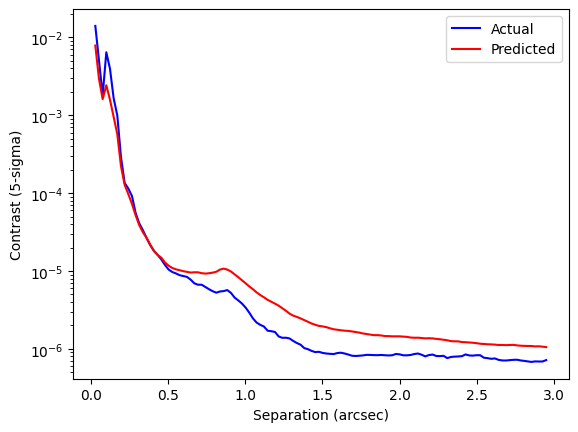

In [16]:
# Plot the predicted values vs the actual ones for one observation
import matplotlib.pyplot as plt

x_plot = df_AD['SEPARATION'].iloc[0]
y_plot = y_test[36]
y_pred_plot = y_pred[36]

plt.plot(x_plot, y_plot, color='blue', label='Actual')
plt.plot(x_plot, y_pred_plot, color='red', label='Predicted')
plt.xlabel('Separation (arcsec)')
plt.ylabel('Contrast (5-sigma)')
plt.yscale(value='log')
plt.legend()
plt.show()


# Multilayer Perceptron

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim

# Convert the data to tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_train_log_tensor = torch.tensor(y_train_log, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
y_test_log_tensor = torch.tensor(y_test_log, dtype=torch.float32)

print("x_train_tensor shape : {}".format(x_train_tensor.shape))
print("y_train_tensor shape : {}".format(y_train_tensor.shape))
print("x_test_tensor shape : {}".format(x_test_tensor.shape))
print("y_test_tensor shape : {}".format(y_test_tensor.shape))

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device : {}".format(device))

x_train_tensor shape : torch.Size([674, 17])
y_train_tensor shape : torch.Size([674, 124])
x_test_tensor shape : torch.Size([169, 17])
y_test_tensor shape : torch.Size([169, 124])
Device : cpu


In [18]:
# Define the model

class MLP(nn.Sequential):
    def __init__(self, input_features, output_features, hidden_features):
        super().__init__(
            nn.Linear(input_features, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, output_features),
        )

input_size = x_train_tensor.shape[1]
hidden_size = 64
output_size = y_train_log_tensor.shape[1]

model = MLP(input_size, output_size, hidden_size)

# Define the loss function and the optimizer
criterion = nn.MSELoss() # Probably not the best choice for this problem but it's just for the example
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="master-thesis",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.001,
    "architecture": "MLP",
    "dataset": "Custom dataset",
    "epochs": 500,
    }
)

In [20]:
# Train the model
num_epochs = 5000
batch_size = 32

for epoch in range(num_epochs):
    # Forward pass
    y_pred_log_tensor = model(x_train_tensor)
    loss = criterion(y_pred_log_tensor, y_train_log_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # log metrics to wandb
    wandb.log({"loss": loss.item()})

wandb.finish()

loss,█▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.01686


In [21]:
# Make predictions on the test set
with torch.no_grad():
    y_pred_log_tensor = model(x_test_tensor)
    y_pred_mlp = y_pred_log_tensor.numpy()
    y_pred_mlp = np.power(10, y_pred_mlp)
    # y_pred_mlp = y_pred_mlp.reshape(-1)

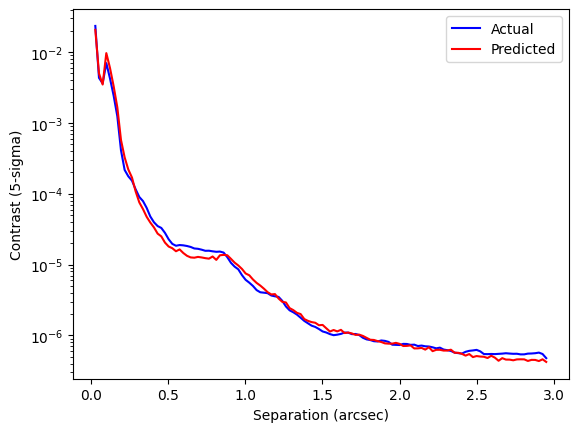

In [24]:
# Plot the predicted values vs the actual ones for one observation
import matplotlib.pyplot as plt

x_plot = df_AD['SEPARATION'].iloc[0]
y_plot = y_test[80]
y_pred_plot = y_pred_mlp[80]

plt.plot(x_plot, y_plot, color='blue', label='Actual')
plt.plot(x_plot, y_pred_plot, color='red', label='Predicted')
plt.xlabel('Separation (arcsec)')
plt.ylabel('Contrast (5-sigma)')
plt.yscale(value='log')
plt.legend()
plt.show()
